In [1]:
from IPython.display import Image,clear_output
%pip install torch torchvision matplotlib albumentations opencv-python segmentation-models-pytorch
%pip install roboflow pandas scikit-learn transformers datasets
%pip uninstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
clear_output()

In [2]:
from roboflow import Roboflow
import os

rf = Roboflow(api_key="4QwtaiJqX1nqiPdAyXcV")
dataset = rf.workspace("dron-hkv6n").project("clasificacion-de-suelo-2").version(14).download("png-mask-semantic", location="content/my-datasets")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, SegformerConfig
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [4]:
# Definir paths
dataset_path = "content/my-datasets"
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")

In [5]:
classes_csv = os.path.join(train_path, "_classes.csv")
classes_df = pd.read_csv(classes_csv)
classes_df.columns = classes_df.columns.str.strip()  # Limpia encabezados

num_classes = len(classes_df)

id2label = {int(row["Pixel Value"]): str(row["Class"]) for _, row in classes_df.iterrows()}
label2id = {v: k for k, v in id2label.items()}

print("Clases:", id2label)

Clases: {0: ' background', 1: ' agua', 2: ' suelo expuesto', 3: ' vegetacion seca', 4: ' vegetacion verde'}


In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, transform=None, feature_extractor=None):
        self.image_dir = image_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png")) and "_mask" not in f])
        self.mask_files = [img.rsplit(".", 1)[0] + "_mask.png" for img in self.image_files]
        self.transform = transform
        self.feature_extractor = feature_extractor

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.image_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.feature_extractor:
            inputs = self.feature_extractor(images=image, return_tensors="pt")
            image = inputs["pixel_values"].squeeze()

        mask = np.array(mask)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

In [7]:
feature_extractor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

config = SegformerConfig.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id
)

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    config=config,
    ignore_mismatched_sizes=True
)

The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([5]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([5, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
train_dataset = SegmentationDataset(train_path, feature_extractor=feature_extractor)
valid_dataset = SegmentationDataset(valid_path, feature_extractor=feature_extractor)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

def train_one_epoch():
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Paso por el modelo
        outputs = model(pixel_values=images)
        logits = outputs.logits  # [B, C, H, W]

        # Redimensionar máscaras al tamaño de los logits
        masks_resized = torch.nn.functional.interpolate(
            masks.unsqueeze(1).float(),           # [B, 1, H, W]
            size=logits.shape[2:],                # tamaño del output
            mode='nearest'                        # mantener clases enteras
        ).squeeze(1).long()                        # [B, H, W]

        # Cálculo de pérdida
        loss = loss_fn(logits, masks_resized)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [10]:
for epoch in range(10):
    loss = train_one_epoch()
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}")

Epoch 1: Loss = 1.0619
Epoch 2: Loss = 0.7276
Epoch 3: Loss = 0.6327
Epoch 4: Loss = 0.5369
Epoch 5: Loss = 0.4694
Epoch 6: Loss = 0.4348
Epoch 7: Loss = 0.4135
Epoch 8: Loss = 0.3897
Epoch 9: Loss = 0.3244
Epoch 10: Loss = 0.3108


In [11]:
import requests

# Reemplaza con tu token y chat ID
TOKEN = "7582937970:AAEjX_QwxmfjTaFEtJB8ooS4DJ9r782xts8"
CHAT_ID = "7127859860"
MENSAJE = "TERMINO DE ENTRENAR"

# URL de la API de Telegram
URL = f"https://api.telegram.org/bot{TOKEN}/sendMessage"

# Parámetros del mensaje
data = {
    "chat_id": CHAT_ID,
    "text": MENSAJE
}

# Enviar el mensaje
respuesta = requests.post(URL, json=data)

In [12]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, masks in valid_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(pixel_values=images)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        # Redimensionar máscaras para que coincidan con los logits
        masks_resized = torch.nn.functional.interpolate(
            masks.unsqueeze(1).float(),
            size=logits.shape[2:],
            mode='nearest'
        ).squeeze(1).long()

        all_preds.extend(preds.cpu().numpy().reshape(-1))
        all_labels.extend(masks_resized.cpu().numpy().reshape(-1))

# Obtener etiquetas y nombres desde el CSV
labels = sorted(id2label.keys())
target_names = [str(id2label[i]) for i in labels]

# Imprimir reporte con nombres de clase
print(classification_report(
    all_labels,
    all_preds,
    labels=labels,
    target_names=target_names,
    zero_division=0,
    digits=4
))

                   precision    recall  f1-score   support

       background     0.0000    0.0000    0.0000         0
             agua     0.8298    0.9496    0.8856     25216
   suelo expuesto     0.9285    0.7701    0.8419    170069
  vegetacion seca     0.8402    0.7820    0.8101    165161
 vegetacion verde     0.5703    0.8905    0.6953     65538

         accuracy                         0.8039    425984
        macro avg     0.6338    0.6784    0.6466    425984
     weighted avg     0.8333    0.8039    0.8096    425984



In [13]:
test_path = os.path.join(dataset_path, "test")
test_dataset = SegmentationDataset(test_path, feature_extractor=feature_extractor)
test_loader = DataLoader(test_dataset, batch_size=2)

In [14]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(pixel_values=images)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        # Redimensionar máscaras
        masks_resized = torch.nn.functional.interpolate(
            masks.unsqueeze(1).float(),
            size=logits.shape[2:],
            mode='nearest'
        ).squeeze(1).long()

        all_preds.extend(preds.cpu().numpy().reshape(-1))
        all_labels.extend(masks_resized.cpu().numpy().reshape(-1))

# Crear labels y nombres
labels = list(id2label.keys())
target_names = list(id2label.values())

# Reporte
print(classification_report(
    all_labels,
    all_preds,
    labels=labels,
    target_names=target_names,
    zero_division=0,
    digits=4
))

                   precision    recall  f1-score   support

       background     0.0000    0.0000    0.0000         0
             agua     0.0000    0.0000    0.0000         0
   suelo expuesto     0.8897    0.8748    0.8822     75446
  vegetacion seca     0.8960    0.5898    0.7114     94411
 vegetacion verde     0.5837    0.9105    0.7114     59519

         accuracy                         0.7668    229376
        macro avg     0.4739    0.4750    0.4610    229376
     weighted avg     0.8129    0.7668    0.7676    229376



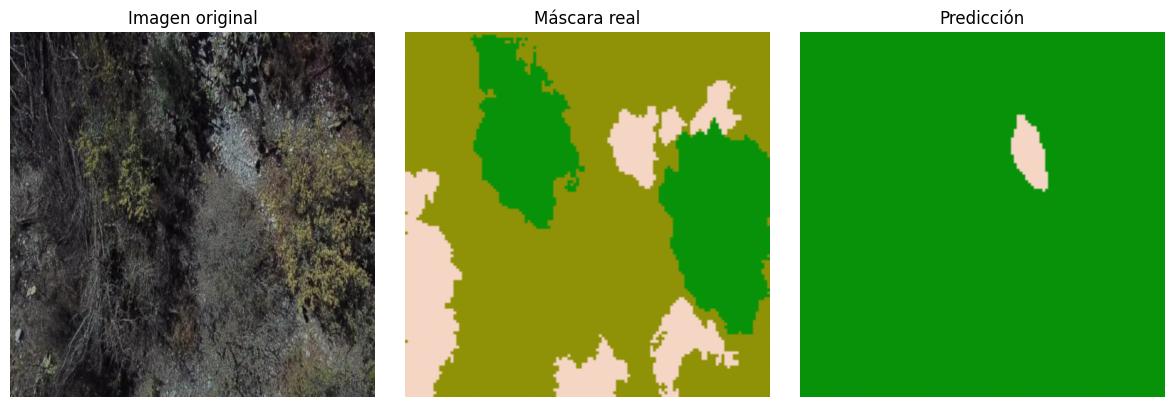

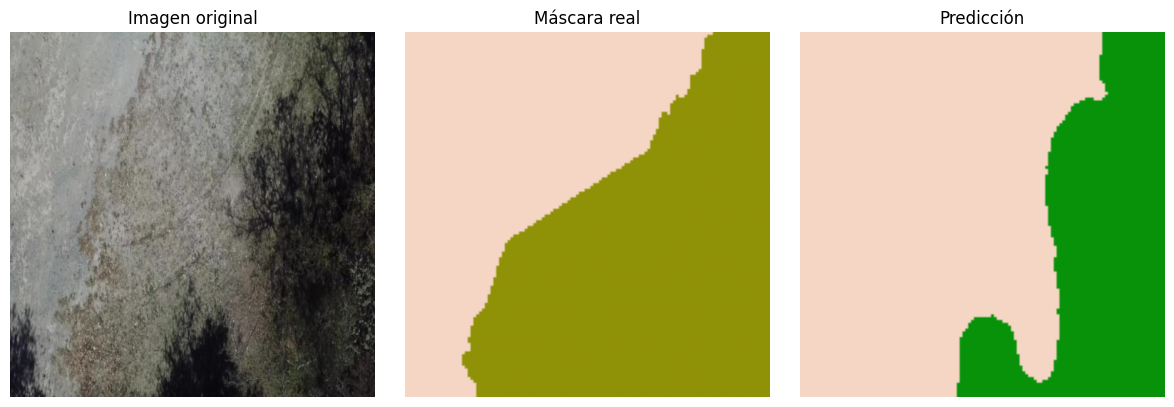

In [15]:
import torch.nn.functional as F
from matplotlib.colors import ListedColormap

# Definir colores personalizados para cada clase
custom_colors = [
    "#000000",  # 0 - Background (Negro)
    "#004fff",  # 1 - Agua (Azul)
    "#f5d6c4",  # 2 - Suelo Expuesto (Blanco)
    "#8f9107",  # 3 - Vegetación Seca (Amarillo)
    "#08920a",  # 4 - Vegetación Verde (Verde)
]

# Crear un colormap personalizado
custom_cmap = ListedColormap(custom_colors)

# Obtener un batch de prueba
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Realizar predicciones
with torch.no_grad():
    outputs = model(pixel_values=images)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1)

    # Redimensionar ground truth
    masks_resized = F.interpolate(
        masks.unsqueeze(1).float(),
        size=logits.shape[2:],
        mode='nearest'
    ).squeeze(1).long()

# Convertir a CPU para visualización
images_np = images.cpu().numpy()
preds_np = preds.cpu().numpy()
masks_np = masks_resized.cpu().numpy()

# Mostrar primeras 3 imágenes con ground truth y predicción
num_to_show = min(3, images_np.shape[0])

# Definir los valores de normalización (ImageNet)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

for i in range(num_to_show):
    plt.figure(figsize=(12, 4))

    # Imagen original desnormalizada
    img = images[i].cpu() * std + mean
    img = torch.clamp(img, 0, 1).numpy()

    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title("Imagen original")
    plt.axis("off")

    # Ground truth
    plt.subplot(1, 3, 2)
    plt.imshow(masks_np[i], cmap=custom_cmap, vmin=0, vmax=num_classes - 1)
    plt.title("Máscara real")
    plt.axis("off")

    # Predicción
    plt.subplot(1, 3, 3)
    plt.imshow(preds_np[i], cmap=custom_cmap, vmin=0, vmax=num_classes - 1)
    plt.title("Predicción")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [16]:
# Guardar todo el modelo
# torch.save(model, "../models/clasificacion4.pth")